<a href="https://colab.research.google.com/github/dinabahar/analyticstest_giantspoon/blob/master/1_merge_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Merge `Media` & `Conversion` Data
### TLDR; I merged the two datasets by using the .merge() function in Pandas. 

To do so, I needed a column that's found in both datasets to merge them *on*. Hence, I concatenated the identifying features: `'Date', 'Platform', 'Placement'` on both datasets to act as unique identifiers. Only then was I able to merge the datasets *on* the `id`'s.

Once the datasets are merged, I split the `id`'s into their respective seperate columns and filled the missing values with 0 to avoid errors in calculations later on.

### I. Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### II. Read `media_data` and `conversion_data`
Create `id`'s by combining `'Date', 'Platform', 'Placement'` data for each onservation (row).

In [ ]:
media = pd.read_csv('/content/drive/My Drive/giant_spoon_analytics_test/media_data.csv')
media['id'] = media['Date'] + ' | ' + media['Platform'] + ' | ' + media['Placement']
media.head(2)

,Date,Platform,Placement,Spend,Impressions,Clicks,id
0,2019-01-04,instagram,LAL_CHI_Purchase,6.63,1339,4,2019-01-04 | instagram | LAL_CHI_Purchase
1,2019-01-04,facebook,RTG_NYC_Cart Add,3.17,133,1,2019-01-04 | facebook | RTG_NYC_Cart Add


In [ ]:
conversion = pd.read_csv('/content/drive/My Drive/giant_spoon_analytics_test/conversion_data.csv')
conversion['id'] = conversion['Date'] + ' | ' + conversion['Source/Medium']
conversion.head(2)

,Date,Source/Medium,Add to Cart,Purchase,Revenue,id
0,2019-01-04,instagram | LAL_NYC_Purchase,1,1,70,2019-01-04 | instagram | LAL_NYC_Purchase
1,2019-01-04,facebook | RTG_CHI_Cart Add,1,1,143,2019-01-04 | facebook | RTG_CHI_Cart Add


### III. Merge datasets *on* `id`'s.

In [ ]:
left = media[['id','Spend','Impressions','Clicks']]
right = conversion[['id','Add to Cart','Purchase','Revenue']]

df = left.merge(right, how='left', on='id')
df

,id,Spend,Impressions,Clicks,Add to Cart,Purchase,Revenue
0,2019-01-04 | instagram | LAL_CHI_Purchase,6.63,1339,4,NaN,NaN,NaN
1,2019-01-04 | facebook | RTG_NYC_Cart Add,3.17,133,1,NaN,NaN,NaN
2,2019-01-04 | instagram | LAL_NYC_Purchase,10.11,2389,14,1.0,1.0,70.0
3,2019-01-04 | facebook | LAL_DC_Purchase,3.14,378,2,NaN,NaN,NaN
4,2019-01-04 | facebook | RTG_CHI_Cart Add,14.41,2488,10,1.0,1.0,143.0
...,...,...,...,...,...,...,...
981,2019-02-28 | instagram | LAL_NYC_Purchase,503.16,15317,30,3.0,3.0,132.0
982,2019-02-28 | instagram | LAL_CHI_Purchase,80.57,2501,5,NaN,NaN,NaN
983,2019-02-28 | instagram | LAL_SFO_Purchase,111.58,2816,11,1.0,1.0,80.0
984,2019-02-28 | instagram | RTG_CHI_SiteVisitor,25.71,863,2,NaN,NaN,NaN


### IV. Split `id`'s into `'Date', 'Platform', 'Placement'` columns.

In [ ]:
new_df = df["id"].str.split("|", n = 2, expand = True)
df['Date'] = new_df[0]
df['Platform'] = new_df[1]
df['Placement'] = new_df[2]

df = df.drop(columns='id')
df.head(2)

,Spend,Impressions,Clicks,Add to Cart,Purchase,Revenue,Date,Platform,Placement
0,6.63,1339,4,NaN,NaN,NaN,2019-01-04,instagram,LAL_CHI_Purchase
1,3.17,133,1,NaN,NaN,NaN,2019-01-04,facebook,RTG_NYC_Cart Add


### V. Handle missing values

Some placement did not yield any conversion and therefore does not have conversion data. Hence, we see `NaN` values when the two datasets were merged.

I'm imputing `NaN` values with 0 to represent 0 conversions made.

In [ ]:
df.isna().sum()

Spend            0
Impressions      0
Clicks           0
Add to Cart    502
Purchase       502
Revenue        502
Date             0
Platform         0
Placement        0
dtype: int64

In [ ]:
df = df.fillna(value=0)

### VI. Reorganizing data

I'm enaming the columns into lowered, snake casing. As well as reorganizing the columns.

In [ ]:
df = df.rename(columns=str.lower)
df = df.rename(columns={'add to cart': 'add_to_cart'})

df = df[['date',	'platform',	'placement', 'spend',	'impressions',	'clicks',	'add_to_cart',	'purchase', 'revenue']]
df.head(2)

,date,platform,placement,spend,impressions,clicks,add_to_cart,purchase,revenue
0,2019-01-04,instagram,LAL_CHI_Purchase,6.63,1339,4,0.0,0.0,0.0
1,2019-01-04,facebook,RTG_NYC_Cart Add,3.17,133,1,0.0,0.0,0.0


### VII. Save data

In [ ]:
df.to_csv('/content/drive/My Drive/giant_spoon_analytics_test/merged_data.csv', index=False)

# 3. Predict March Purchases

### Imports

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error

Set `'date'` as index and group purchase data by date.

In [ ]:
df['date'] = pd.to_datetime(df['date'])
purchases = df.groupby('date')[['purchase']].mean()

Check for seasonality:

There seems to be a weekly pattern.

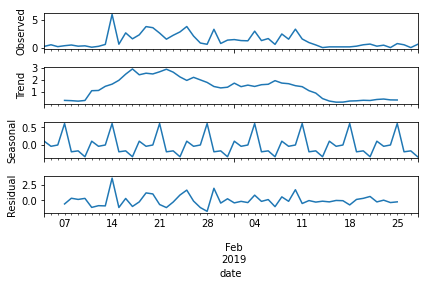

In [ ]:
decomp = seasonal_decompose(purchases['purchase'])

decomp.plot();

Check autocorrelation to see how much to lag.

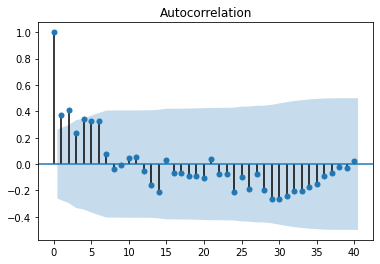

In [ ]:
plot_acf(purchases['purchase'], lags = 40);

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1350: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k] * X[k:]).sum() / denom(k)


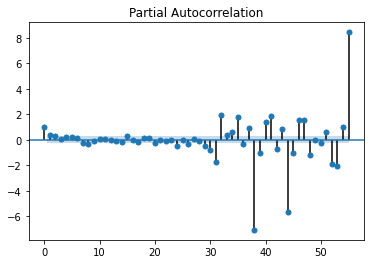

In [ ]:
plot_pacf(purchases['purchase'], lags = 60);

Create a column called `lag_38` that lags purchases by 38 days.

In [ ]:
purchases['lag_38'] = purchases['purchase'].shift(38)

purchases.head()

,purchase,lag_38
date,,
2019-01-04,0.208333,NaN
2019-01-05,0.500000,NaN
2019-01-06,0.166667,NaN
2019-01-07,0.333333,NaN
2019-01-08,0.458333,NaN


In [ ]:
purchases.tail()

,purchase,lag_38
date,,
2019-02-24,0.000000,1.562500
2019-02-25,0.714286,2.277778
2019-02-26,0.500000,3.750000
2019-02-27,0.000000,3.555556
2019-02-28,0.571429,2.588235


### Pre-Modeling

Generate train/test split.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(purchases.drop(columns = 'purchase'),
                                                    purchases['purchase'],
                                                    test_size = 0.25,
                                                    shuffle = False)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42, 1)
(14, 1)
(42,)
(14,)


Add constant to model with `statsmodels`.

In [ ]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

Drop missing values from lags because `statsmodels` won't work on missing values. Subset y_train to keep only indices from X_train.

In [ ]:
X_train.dropna(inplace=True)
y_train = y_train[X_train.index] 

### Instantiate & fit model

Interpreting Summary:

- 

In [ ]:
lm = sm.OLS(y_train, X_train)
lm_results = lm.fit()

print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:               purchase   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.483
Method:                 Least Squares   F-statistic:                   0.02263
Date:                Mon, 13 Jul 2020   Prob (F-statistic):              0.894
Time:                        16:21:19   Log-Likelihood:                -3.3678
No. Observations:                   4   AIC:                             10.74
Df Residuals:                       2   BIC:                             9.508
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8639      1.007      0.858      0.4

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


In [ ]:
lm_results.predict(X_test)

date
2019-02-15    0.652819
2019-02-16    0.748780
2019-02-17    0.719992
2019-02-18    0.835145
2019-02-19    0.761575
2019-02-20    0.604839
2019-02-21   -1.870954
2019-02-22    0.587566
2019-02-23   -0.345175
2019-02-24    0.144226
2019-02-25   -0.185240
2019-02-26   -0.863364
2019-02-27   -0.773800
2019-02-28   -0.328241
dtype: float64

In [ ]:
X_test

,const,lag_38
date,,
2019-02-15,1.0,0.458333
2019-02-16,1.0,0.250000
2019-02-17,1.0,0.312500
2019-02-18,1.0,0.062500
2019-02-19,1.0,0.222222
2019-02-20,1.0,0.562500
2019-02-21,1.0,5.937500
2019-02-22,1.0,0.600000
2019-02-23,1.0,2.625000


In [ ]:
r2_score(y_test, lm_results.predict(X_test))

-16.03612964416618

In [ ]:
mean_squared_error(y_test, lm_results.predict(X_test)) ** 0.5

0.95760184686084

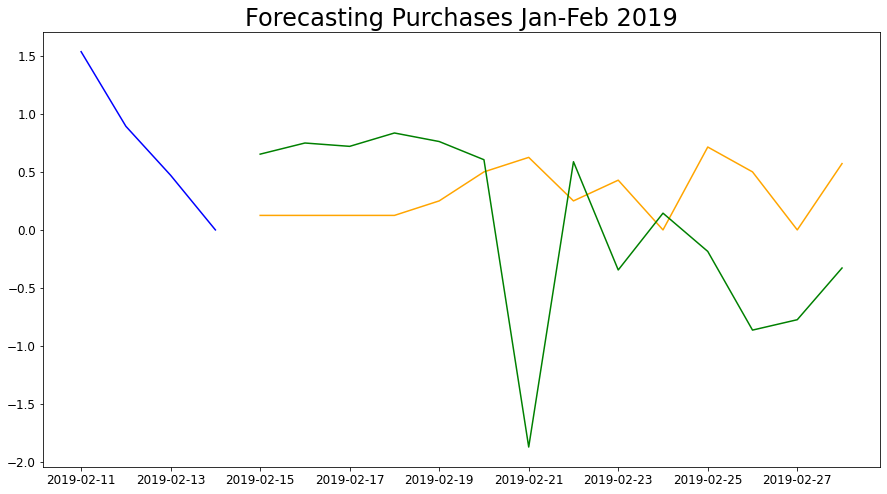

In [ ]:
plt.figure(figsize=(15,8))

# Plot training data.
plt.plot(y_train.index, y_train.values, color = 'blue')

# Plot testing data.
plt.plot(y_test.index, y_test.values, color = 'orange')

# Plot predicted test values.
plt.plot(lm_results.predict(X_test), color = 'green')

# Set label.
plt.title(label = 'Forecasting Purchases Jan-Feb 2019', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [ ]:
X_test

,const,lag_38
date,,
2019-02-15,1.0,0.458333
2019-02-16,1.0,0.250000
2019-02-17,1.0,0.312500
2019-02-18,1.0,0.062500
2019-02-19,1.0,0.222222
2019-02-20,1.0,0.562500
2019-02-21,1.0,5.937500
2019-02-22,1.0,0.600000
2019-02-23,1.0,2.625000


In [ ]:
march = pd.read_csv('/content/drive/My Drive/giant_spoon_analytics_test/march_dates.csv')
march.head(2)

,Dates,Purchases
0,2019-03-01,NaN
1,2019-03-02,NaN
